In [1]:
import re
import numpy as np

import tensorflow.compat.v2 as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib
import matplotlib.pyplot as plt

import os, glob, types
from collections import defaultdict
import math

Credit: 
- Base model and fine-tuning reference:  https://github.com/google-research/simclr/blob/master/tf2/colabs/finetuning.ipynb
- Used chatgpt for data processing, debugging,and ploting code

Load dataset from roboflow

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="1OKC50ZfMpo6wMPxEVig")
project = rf.workspace("yaid-pzikt").project("firefighting-device-detection")
version = project.version(6)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


Simclr is usually used for image classifiction rather than object detection so I crop into the bounding box and create a dataset for classfication.

In [4]:
import os, glob, yaml
from pathlib import Path
from PIL import Image

ROOT = "Firefighting-Device-Detection-6"   # folder containing train/, valid/, test/
OUT  = "data_crops"                    # ImageFolder output
PATCH = 160                            # output patch size
PAD = 8                                # context pixels around box
MIN_PX = 6                             # skip tiny boxes

def read_names(root):
    yml = os.path.join(root, "data.yaml")
    if os.path.exists(yml):
        with open(yml) as f:
            d = yaml.safe_load(f)
        names = d.get("names")
        if isinstance(names, dict):    # {0:'cls0',1:'cls1',...}
            return [names[k] for k in sorted(names.keys())]
        return names                   # ['cls0','cls1',...]
    return None

NAMES = read_names(ROOT)

def ensure(d): os.makedirs(d, exist_ok=True)

def yolo_boxes(txt_path, W, H):
    boxes = []
    if not os.path.exists(txt_path): return boxes
    with open(txt_path) as f:
        for line in f:
            p = line.strip().split()
            if len(p) != 5: continue
            c, xc, yc, w, h = int(p[0]), float(p[1]), float(p[2]), float(p[3]), float(p[4])
            cx, cy = xc*W, yc*H; bw, bh = w*W, h*H
            x0 = max(0, int(cx - bw/2) - PAD)
            y0 = max(0, int(cy - bh/2) - PAD)
            x1 = min(W, int(cx + bw/2) + PAD)
            y1 = min(H, int(cy + bh/2) + PAD)
            if (x1-x0) < MIN_PX or (y1-y0) < MIN_PX: continue
            boxes.append((c, x0, y0, x1, y1))
    return boxes

for split in ["train", "valid", "test"]:
    img_dir = os.path.join(ROOT, split, "images")
    lab_dir = os.path.join(ROOT, split, "labels")
    for ip in sorted(glob.glob(os.path.join(img_dir, "*.*"))):
        im = Image.open(ip).convert("RGB")
        W, H = im.size
        ann = os.path.join(lab_dir, Path(ip).stem + ".txt")
        for k, (cid, x0, y0, x1, y1) in enumerate(yolo_boxes(ann, W, H)):
            cls = (NAMES[cid] if NAMES and cid < len(NAMES) else f"class_{cid}")
            out_dir = os.path.join(OUT, "train" if split=="train" else ("val" if split=="valid" else "test"), cls)
            ensure(out_dir)
            crop = im.crop((x0, y0, x1, y1)).resize((PATCH, PATCH), Image.BILINEAR)
            crop.save(os.path.join(out_dir, f"{Path(ip).stem}_{k}.jpg"))

print("Done. Crops in", OUT)

Done. Crops in data_crops


Create tensorflow dataset fromt the above generated crop in images

In [2]:
def create_tf_ds(
    root_dir,
    img_size=(224, 224),
    batch_size=64,
    shuffle=True,
    class_names_order=None,   # <- canonical order; if None, infer from this dir
    allow_unknown=False       # <- if True, keep unknown classes with label = -1
):
    H, W = img_size

    # --- choose preprocessing ---
    def preprocess_image_fallback(img, h, w, is_training=False, color_distort=False):
        img = tf.image.resize(img, [h, w])
        img = tf.cast(img, tf.float32) / 255.0
        return img

    USE_SIMCLR_PREPROCESS = 'preprocess_image' in globals()
    def _preprocess_image(img, h, w, is_training=False, color_distort=False):
        if USE_SIMCLR_PREPROCESS:
            return preprocess_image(img, h, w, is_training=is_training, color_distort=color_distort)
        return preprocess_image_fallback(img, h, w, is_training=is_training, color_distort=color_distort)

    # --- discover local classes ---
    local_classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])

    # --- decide canonical classes & mapping ---
    if class_names_order is None:
        class_names = local_classes
    else:
        class_names = list(class_names_order)  # keep exact order from train

    class_to_id = {c: i for i, c in enumerate(class_names)}

    # --- collect files, respecting canonical mapping ---
    image_files, labels, kept_classes = [], [], set()
    unknown_files, unknown_classes = [], set()

    for c in local_classes:
        files = sorted(glob.glob(os.path.join(root_dir, c, "*.*")))
        if c in class_to_id:
            cid = class_to_id[c]
            image_files.extend(files)
            labels.extend([cid] * len(files))
            kept_classes.add(c)
        else:
            if allow_unknown:
                image_files.extend(files)
                labels.extend([-1] * len(files))  # unknown class label
                unknown_classes.add(c)
                unknown_files.extend(files)
            else:
                # silently drop unknowns; you can log if you prefer
                unknown_classes.add(c)
                unknown_files.extend(files)

    num_images = len(image_files)
    print(f"[create_tf_ds] {root_dir} | local_classes={len(local_classes)} "
          f"| canonical_classes={len(class_names)} | kept={len(kept_classes)} "
          f"| unknown={len(unknown_classes)} | images={num_images}")

    AUTOTUNE = tf.data.AUTOTUNE

    def _parse_and_preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img.set_shape([None, None, 3])
        img = _preprocess_image(img, H, W, is_training=False, color_distort=False)
        return {"image": img, "label": label}

    ds = (tf.data.Dataset
            .from_tensor_slices((image_files, labels))
            .map(_parse_and_preprocess, num_parallel_calls=AUTOTUNE))

    if not allow_unknown:
        # filter out any -1 labels if they exist (shouldn't if allow_unknown=False)
        ds = ds.filter(lambda x: tf.greater_equal(x["label"], 0))

    if shuffle:
        ds = ds.shuffle(buffer_size=num_images, reshuffle_each_iteration=True)

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)

    tfds_info = types.SimpleNamespace(
        splits={"train": types.SimpleNamespace(num_examples=num_images)},
        features=types.SimpleNamespace(
            label=types.SimpleNamespace(num_classes=len(class_names))
        ),
        class_names=class_names,
        class_to_id=class_to_id,
        kept_classes=sorted(list(kept_classes)),
        unknown_classes=sorted(list(unknown_classes)),
    )
    return ds, tfds_info

In [3]:
train_ds, train_info = create_tf_ds("data_crops/train", img_size=(224,224), batch_size=64, shuffle=True)
num_classes = len(train_info.class_names)   # model head should match this

[create_tf_ds] data_crops/train | local_classes=40 | canonical_classes=40 | kept=40 | unknown=0 | images=2606


In [4]:
test_ds, test_info = create_tf_ds(
    "data_crops/test",
    img_size=(224,224),
    batch_size=64,
    shuffle=True,
    class_names_order=train_info.class_names,   # <- forces identical indices
    allow_unknown=False                         # <- drop classes not in train
)

val_ds, val_info = create_tf_ds(
    "data_crops/val",
    img_size=(224,224),
    batch_size=64,
    shuffle=True,
    class_names_order=train_info.class_names,   # <- forces identical indices
    allow_unknown=False                         # <- drop classes not in train
)

print("Test kept classes:", test_info.kept_classes)
print("Test unknown classes (dropped):", test_info.unknown_classes)

print("Test kept classes:", val_info.kept_classes)
print("Test unknown classes (dropped):", val_info.unknown_classes)

[create_tf_ds] data_crops/test | local_classes=30 | canonical_classes=40 | kept=30 | unknown=0 | images=424
[create_tf_ds] data_crops/val | local_classes=33 | canonical_classes=40 | kept=32 | unknown=1 | images=754
Test kept classes: ['24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'emergency-manual-start-stop-button', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'gas-spray-audible-and-visual-alarm', 'i-o-module', 'input-module', 'light-display', 'manual-alarm-button-with-fire-telephone-jack', 'manual-automatic-switching-device', 'normally-open-smoke-exhaust-valve-with-280-operation', 'normally-open-smoke-exhaust-valve-with-70-operation', 'normally-open-smoke-exhaust-valve-with-70-op

In [5]:
from tensorflow.keras import layers
try:
    from tensorflow_addons.optimizers import LARS as Optim
except Exception:
    Optim = lambda learning_rate, momentum: tf.keras.optimizers.SGD(learning_rate, momentum=momentum, nesterov=True)


We define a model by adding a classification head on the last layer output from Simclr.

In [12]:
class SimCLRLinearClassifier(tf.keras.Model):
    def __init__(self, simclr_path, num_classes, weight_decay=0.0):
        super().__init__()
   
        self.encoder = tf.saved_model.load(simclr_path)
        # Linear head
        self.head = layers.Dense(
            num_classes,
            name="linear_head",
            kernel_regularizer=(tf.keras.regularizers.l2(weight_decay) if weight_decay > 0 else None)
        )

    def call(self, images, training=False):
        # Forward through encoder
        feats = self.encoder(images, trainable=False)['final_avg_pool']
        if not training:
            feats = tf.stop_gradient(feats)     # keep encoder frozen in eval
        # Classification head
        logits = self.head(feats, training=training)
        return logits

    @tf.function(jit_compile=False)
    def train_step(self, batch, optimizer, l2_reg_weight=0.0):
        """One optimization step on the linear head."""
        images, labels = batch['image'], batch['label']
        with tf.GradientTape() as tape:
            logits = self(images, training=True)  # builds head vars on first call
            ce = tf.reduce_mean(
                tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
            )
            if l2_reg_weight > 0.0 and self.head.trainable_variables:
                l2 = tf.add_n([tf.nn.l2_loss(v) for v in self.head.trainable_variables if "bias" not in v.name])
                loss = ce + l2_reg_weight * l2
            else:
                loss = ce

        train_vars = list(self.head.trainable_variables)
        if train_vars:  # guard in case first call hasn’t created vars (warm-up recommended)
            grads = tape.gradient(loss, train_vars)
            grads_vars = [(g, v) for g, v in zip(grads, train_vars) if g is not None]
            if grads_vars:
                optimizer.apply_gradients(grads_vars)

        preds = tf.argmax(logits, axis=-1, output_type=labels.dtype)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, labels), tf.float32))
        return loss, acc

    @tf.function(jit_compile=False)
    def eval_step(self, batch, l2_reg_weight=0.0):
        """One evaluation step (no optimizer)."""
        images, labels = batch['image'], batch['label']
        logits = self(images, training=False)
        ce = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
        )
        if l2_reg_weight > 0.0 and self.head.trainable_variables:
            l2 = tf.add_n([tf.nn.l2_loss(v) for v in self.head.trainable_variables if "bias" not in v.name])
            loss = ce + l2_reg_weight * l2
        else:
            loss = ce
        preds = tf.argmax(logits, axis=-1, output_type=labels.dtype)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, labels), tf.float32))
        return loss, acc

    def evaluate(self, eval_ds, max_batches=None, l2_reg_weight=0.0):
        """Aggregate eval over a dataset."""
        loss_m = tf.keras.metrics.Mean()
        acc_m  = tf.keras.metrics.Mean()
        for i, batch in enumerate(eval_ds):
            if max_batches is not None and i >= max_batches:
                break
            loss, acc = self.eval_step(batch, l2_reg_weight=l2_reg_weight)
            loss_m.update_state(loss)
            acc_m.update_state(acc)
        return float(loss_m.result().numpy()), float(acc_m.result().numpy())


In [17]:
def train(
    model,
    train_ds,
    eval_ds=None,
    *,
    epochs=5,
    optimizer=None,
    l2_reg_weight=1e-4,
    log_every=10,          # record/print every 10 steps
    eval_every=50,         # evaluate every 50 steps
    eval_max_batches=None, # None = full eval set
    ckpt_path=None
):
    # Warm-up to ensure head variables exist before optimizer creates slots
    if not getattr(model.head, "built", False) or not model.head.trainable_variables:
        sample_batch = next(iter(train_ds))
        _ = model(sample_batch['image'][:1], training=True)

    if optimizer is None:
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

    logs = defaultdict(list)
    global_step = 0
    best_val_acc = -1.0

    # Running-average metrics for pretty prints
    train_loss_metric = tf.keras.metrics.Mean(name="train_loss")
    train_acc_metric  = tf.keras.metrics.Mean(name="train_acc")

    for epoch in range(epochs):
        print(f"\n=== Epoch {epoch+1}/{epochs} ===")
        train_loss_metric.reset_state()
        train_acc_metric.reset_state()

        for step, batch in enumerate(train_ds):
            global_step += 1

            # one step (uses your model.train_step method)
            loss, acc = model.train_step(batch, optimizer=optimizer, l2_reg_weight=l2_reg_weight)

            # update running means
            train_loss_metric.update_state(loss)
            train_acc_metric.update_state(acc)

            # record + print every N steps
            if global_step % log_every == 0:
                logs["step"].append(global_step)
                logs["train_loss"].append(float(loss.numpy()))
                logs["train_acc"].append(float(acc.numpy()))
                print(f"[step {global_step:4d}] "
                      f"loss={train_loss_metric.result():.4f}  acc={train_acc_metric.result():.3f}")

            # periodic evaluation
            if eval_ds is not None and global_step % eval_every == 0:
                vloss, vacc = model.evaluate(eval_ds, max_batches=eval_max_batches, l2_reg_weight=l2_reg_weight)
                logs["val_step"].append(global_step)
                logs["val_loss"].append(vloss)
                logs["val_acc"].append(vacc)
                print(f"    Eval @ step {global_step:4d}: "
                      f"val_loss={vloss:.4f}  val_acc={vacc:.3f}")

                # checkpoint best
                if ckpt_path and vacc > best_val_acc:
                    best_val_acc = vacc
                    model.save_weights(ckpt_path)
                    print(f"     New best val_acc={vacc:.4f} → saved weights to {ckpt_path}")

        # Optional end-of-epoch eval summary
        if eval_ds is not None:
            vloss, vacc = model.evaluate(eval_ds, max_batches=eval_max_batches, l2_reg_weight=l2_reg_weight)
            logs["val_step"].append(global_step)
            logs["val_loss"].append(vloss)
            logs["val_acc"].append(vacc)
            print(f"[Epoch {epoch+1:02d} End] "
                  f"train_loss={train_loss_metric.result():.4f}  train_acc={train_acc_metric.result():.3f}  "
                  f"val_loss={vloss:.4f}  val_acc={vacc:.3f}")

    print("\n Training complete.")
    return logs


def plot_logs(
    logs,
    *,
    learning_rate=None,
    momentum=None,
    l2_reg_weight=None,
    title_prefix="SimCLR Linear Probe"
):
    if not logs.get("step"):
        print("no logs to plot.")
        return

    plt.figure(figsize=(12, 4))

    # ---------- Loss ----------
    plt.subplot(1, 2, 1)
    plt.plot(logs["step"], logs["train_loss"], label="train")
    if logs.get("val_loss"):
        plt.plot(logs["val_step"], logs["val_loss"], 'o--', label="val")
    plt.xlabel("Step")
    plt.ylabel("Loss")

    hp_str = []
    if learning_rate is not None: hp_str.append(f"LR={learning_rate}")
    if momentum is not None:      hp_str.append(f"Momentum={momentum}")
    if l2_reg_weight is not None: hp_str.append(f"L2={l2_reg_weight}")

    title_loss = f"{title_prefix} | Loss"
    if hp_str:
        title_loss += "\n(" + ", ".join(hp_str) + ")"
    plt.title(title_loss)
    plt.legend()

    # ---------- Accuracy ----------
    plt.subplot(1, 2, 2)
    plt.plot(logs["step"], logs["train_acc"], label="train")
    if logs.get("val_acc"):
        plt.plot(logs["val_step"], logs["val_acc"], 'o--', label="val")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")

    title_acc = f"{title_prefix} | Accuracy"
    if hp_str:
        title_acc += "\n(" + ", ".join(hp_str) + ")"
    plt.title(title_acc)
    plt.legend()

    plt.tight_layout()
    plt.show()


Load the pretained Simclr and construct our classification model.

In [ ]:
simclr_path = "gs://simclr-checkpoints-tf2/simclrv2/finetuned_100pct/r50_1x_sk0/saved_model/"
num_classes = train_info.features.label.num_classes
model = SimCLRLinearClassifier(simclr_path, num_classes, weight_decay=0.0) 

#
#

Finetune the model on our dataset and record the loss and accuracy.

In [15]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

logs = train(
    model,
    train_ds=train_ds,
    eval_ds=val_ds,
    epochs=5,
    optimizer=opt,
    l2_reg_weight=1e-4,
    log_every=10,
    eval_every=50,
    eval_max_batches=50,
    ckpt_path="best_linear_probe.weights.h5"
)


=== Epoch 1/5 ===
[step   10] loss=2.6432  acc=0.398
[step   20] loss=2.1227  acc=0.502
[step   30] loss=1.8640  acc=0.578
[step   40] loss=1.6971  acc=0.619


2025-10-13 19:01:11.907502: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-13 19:01:28.467499: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[Epoch 01 End] train_loss=1.6745  train_acc=0.623  val_loss=0.9503  val_acc=0.774

=== Epoch 2/5 ===
[step   50] loss=1.0011  acc=0.795
    Eval @ step   50: val_loss=0.7988  val_acc=0.853
    🔎 New best val_acc=0.8526 → saved weights to best_linear_probe.weights.h5
[step   60] loss=0.8876  acc=0.824
[step   70] loss=0.8533  acc=0.830
[step   80] loss=0.8108  acc=0.837


2025-10-13 19:02:45.499703: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[Epoch 02 End] train_loss=0.8071  train_acc=0.837  val_loss=0.5808  val_acc=0.914

=== Epoch 3/5 ===
[step   90] loss=0.6329  acc=0.883
[step  100] loss=0.6127  acc=0.885
    Eval @ step  100: val_loss=0.4634  val_acc=0.920
    🔎 New best val_acc=0.9204 → saved weights to best_linear_probe.weights.h5
[step  110] loss=0.5700  acc=0.896
[step  120] loss=0.5548  acc=0.897


2025-10-13 19:04:42.649788: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[Epoch 03 End] train_loss=0.5443  train_acc=0.899  val_loss=0.4070  val_acc=0.935

=== Epoch 4/5 ===
[step  130] loss=0.3977  acc=0.920
[step  140] loss=0.4231  acc=0.925
[step  150] loss=0.4274  acc=0.922
    Eval @ step  150: val_loss=0.3547  val_acc=0.941
    🔎 New best val_acc=0.9407 → saved weights to best_linear_probe.weights.h5
[step  160] loss=0.4134  acc=0.928
[Epoch 04 End] train_loss=0.4064  train_acc=0.929  val_loss=0.3100  val_acc=0.943

=== Epoch 5/5 ===
[step  170] loss=0.3339  acc=0.930
[step  180] loss=0.3378  acc=0.940
[step  190] loss=0.3311  acc=0.942
[step  200] loss=0.3242  acc=0.947
    Eval @ step  200: val_loss=0.2677  val_acc=0.965
    🔎 New best val_acc=0.9647 → saved weights to best_linear_probe.weights.h5
[Epoch 05 End] train_loss=0.3248  train_acc=0.947  val_loss=0.2672  val_acc=0.962

 Training complete.


The Loss and Accuracy plot for the first try with learning rate = 0.01, momentum = 0.9 and the l2_weight_reg_weight for classification head 0.0001.

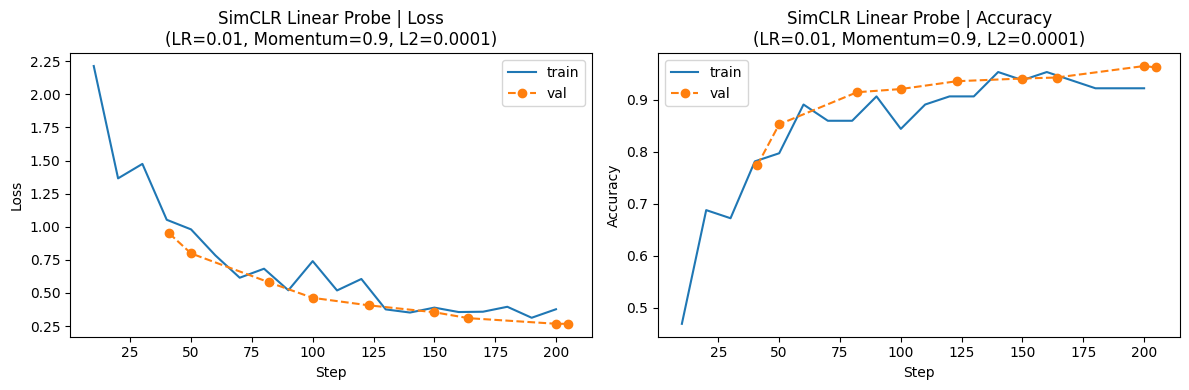

In [16]:
plot_logs(
    logs,
    learning_rate=0.01,
    momentum=0.9,
    l2_reg_weight=1e-4,
    title_prefix="SimCLR Linear Probe"
)

We load the best model from the first trial and view the predictions on some testing set.

In [18]:
ckpt_path = "best_linear_probe.weights.h5"   # same path you used in train(..., ckpt_path=...)
model.load_weights(ckpt_path)

In [19]:
class_names = train_info.class_names
def show_predictions(model, test_ds, class_names, num_images=9):
    rows = cols = int(math.ceil(num_images ** 0.5))
    plt.figure(figsize=(4*cols, 4*rows))
    shown = 0

    for batch in test_ds:
        images, labels = batch["image"], batch["label"]
        # Forward pass with the classifier model (encoder+head)
        logits = model(images, training=False)
        preds  = tf.argmax(logits, axis=-1)

        for i in range(images.shape[0]):
            if shown >= num_images:
                plt.tight_layout()
                plt.show()
                return

            ax = plt.subplot(rows, cols, shown + 1)
            img = images[i].numpy()
            true_id = int(labels[i].numpy())
            pred_id = int(preds[i].numpy())

            # Optional: show probability
            prob = float(tf.nn.softmax(logits[i])[pred_id].numpy())

            ax.imshow(img)
            ax.axis("off")
            color = "green" if pred_id == true_id else "red"
            ax.set_title(
                f"P: {class_names[pred_id]} ({prob:.2f})\nT: {class_names[true_id]}",
                color=color, fontsize=10
            )
            shown += 1

    plt.tight_layout()
    plt.show()

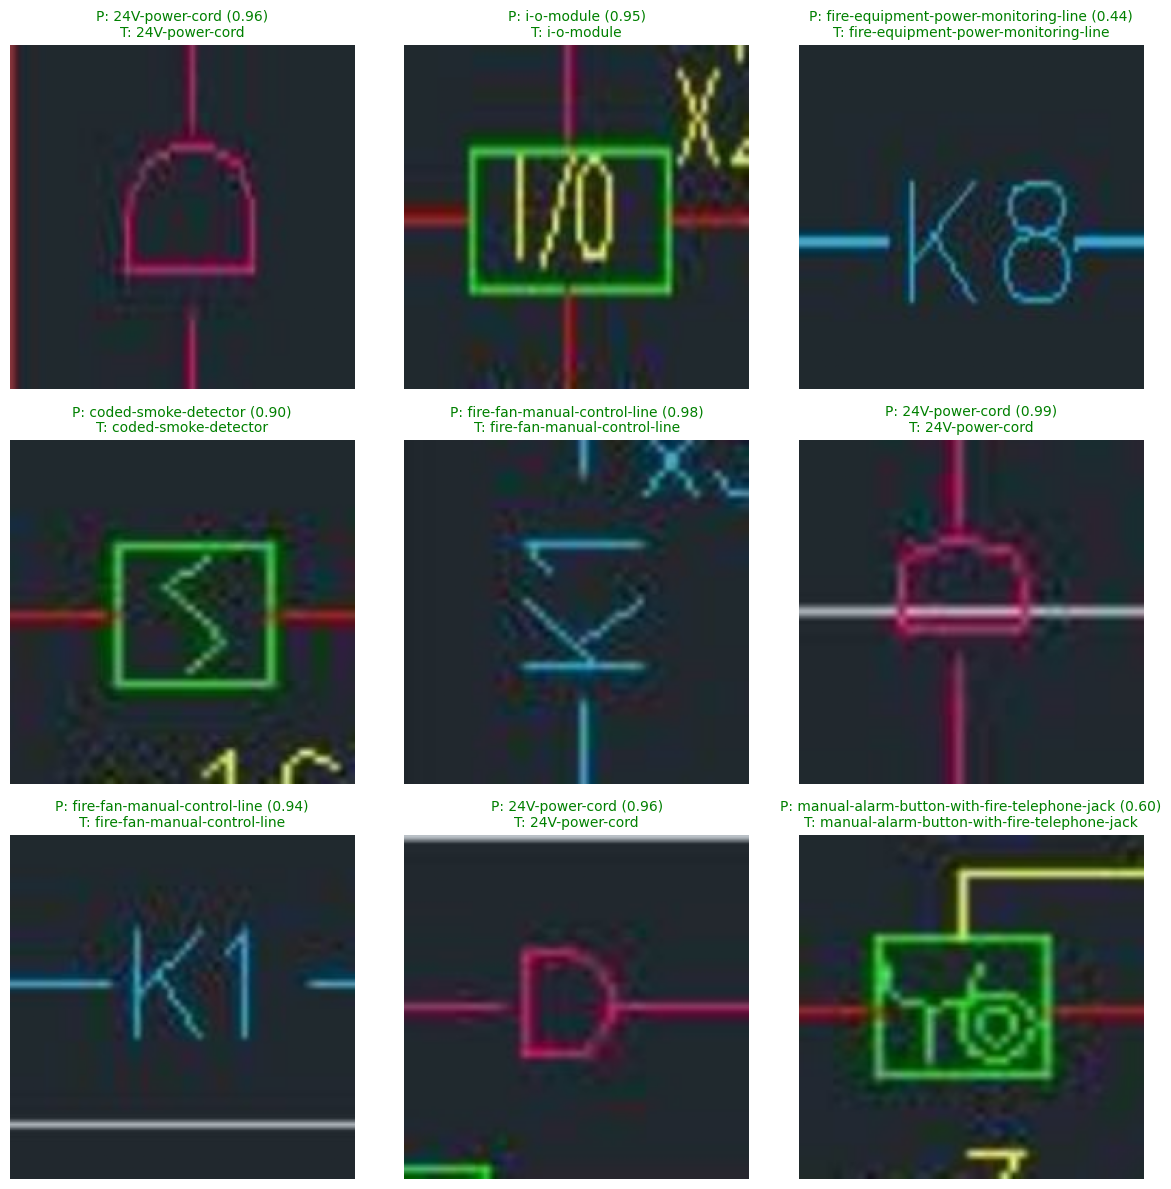

In [21]:
show_predictions(model, test_ds, class_names, num_images=9)

In [28]:
simclr_path = "gs://simclr-checkpoints-tf2/simclrv2/finetuned_100pct/r50_1x_sk0/saved_model/"
num_classes = train_info.features.label.num_classes
model_2 = SimCLRLinearClassifier(simclr_path, num_classes, weight_decay=0.0)

In [29]:
opt_2 = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9, nesterov=True)
logs_2 = train(
    model_2,
    train_ds=train_ds,
    eval_ds=val_ds,
    epochs=5,
    optimizer=opt_2,
    l2_reg_weight=5e-3,
    log_every=10,
    eval_every=50,
    eval_max_batches=50,
    ckpt_path="best_linear_probe2.weights.h5"
)


=== Epoch 1/5 ===
[step   10] loss=3.0483  acc=0.308
[step   20] loss=2.5095  acc=0.443
[step   30] loss=2.2890  acc=0.507
[step   40] loss=2.1231  acc=0.552


2025-10-13 19:23:08.087986: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[Epoch 01 End] train_loss=2.1046  train_acc=0.557  val_loss=1.4140  val_acc=0.732

=== Epoch 2/5 ===
[step   50] loss=1.4156  acc=0.752
    Eval @ step   50: val_loss=1.3115  val_acc=0.765
     New best val_acc=0.7653 → saved weights to best_linear_probe2.weights.h5
[step   60] loss=1.3872  acc=0.758
[step   70] loss=1.3755  acc=0.760
[step   80] loss=1.3202  acc=0.772
[Epoch 02 End] train_loss=1.3087  train_acc=0.775  val_loss=1.0678  val_acc=0.815

=== Epoch 3/5 ===
[step   90] loss=1.1669  acc=0.779
[step  100] loss=1.1195  acc=0.805
    Eval @ step  100: val_loss=0.9802  val_acc=0.843
     New best val_acc=0.8429 → saved weights to best_linear_probe2.weights.h5
[step  110] loss=1.0934  acc=0.814
[step  120] loss=1.0615  acc=0.822
[Epoch 03 End] train_loss=1.0513  train_acc=0.827  val_loss=0.8771  val_acc=0.876

=== Epoch 4/5 ===
[step  130] loss=0.9657  acc=0.850
[step  140] loss=0.9248  acc=0.864
[step  150] loss=0.9041  acc=0.870
    Eval @ step  150: val_loss=0.7918  val_acc=0.8

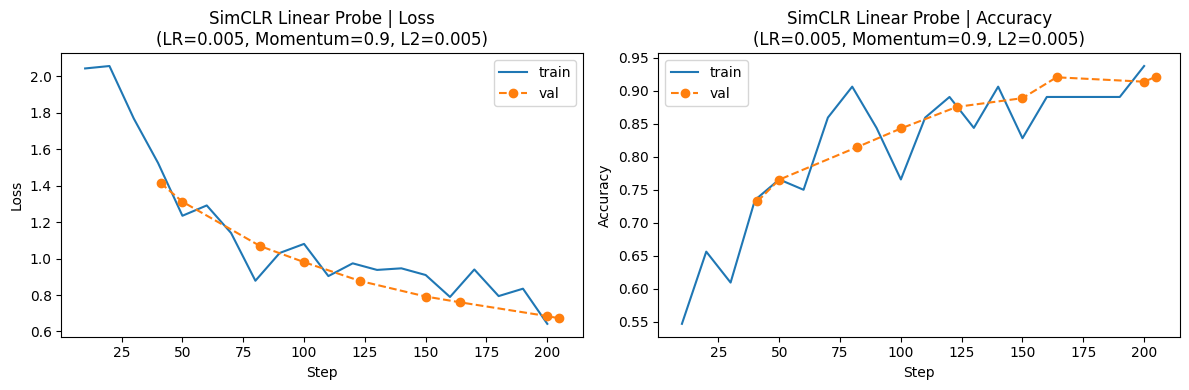

In [30]:
plot_logs(
    logs_2,
    learning_rate=0.005,
    momentum=0.9,
    l2_reg_weight=5e-3
)

In [33]:
simclr_path = "gs://simclr-checkpoints-tf2/simclrv2/finetuned_100pct/r50_1x_sk0/saved_model/"
num_classes = train_info.features.label.num_classes
model_3 = SimCLRLinearClassifier(simclr_path, num_classes, weight_decay=0.0)

opt_3 = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.95, nesterov=True)
logs_3 = train(
    model_3,
    train_ds=train_ds,
    eval_ds=val_ds,
    epochs=5,
    optimizer=opt_3,
    l2_reg_weight=1e-4,
    log_every=10,
    eval_every=50,
    eval_max_batches=50,
    ckpt_path="best_linear_probe3.weights.h5"
)



=== Epoch 1/5 ===
[step   10] loss=2.3835  acc=0.384
[step   20] loss=2.0094  acc=0.523
[step   30] loss=1.7563  acc=0.595
[step   40] loss=1.5530  acc=0.642
[Epoch 01 End] train_loss=1.5275  train_acc=0.649  val_loss=0.7348  val_acc=0.856

=== Epoch 2/5 ===
[step   50] loss=0.7465  acc=0.842
    Eval @ step   50: val_loss=0.6000  val_acc=0.893
     New best val_acc=0.8931 → saved weights to best_linear_probe3.weights.h5
[step   60] loss=0.6787  acc=0.859
[step   70] loss=0.6239  acc=0.874
[step   80] loss=0.5677  acc=0.883
[Epoch 02 End] train_loss=0.5613  train_acc=0.884  val_loss=0.3330  val_acc=0.940

=== Epoch 3/5 ===
[step   90] loss=0.3117  acc=0.953
[step  100] loss=0.3326  acc=0.946
    Eval @ step  100: val_loss=0.2498  val_acc=0.961
     New best val_acc=0.9606 → saved weights to best_linear_probe3.weights.h5
[step  110] loss=0.3334  acc=0.941
[step  120] loss=0.3097  acc=0.947
[Epoch 03 End] train_loss=0.3080  train_acc=0.945  val_loss=0.2095  val_acc=0.967

=== Epoch 4/5 

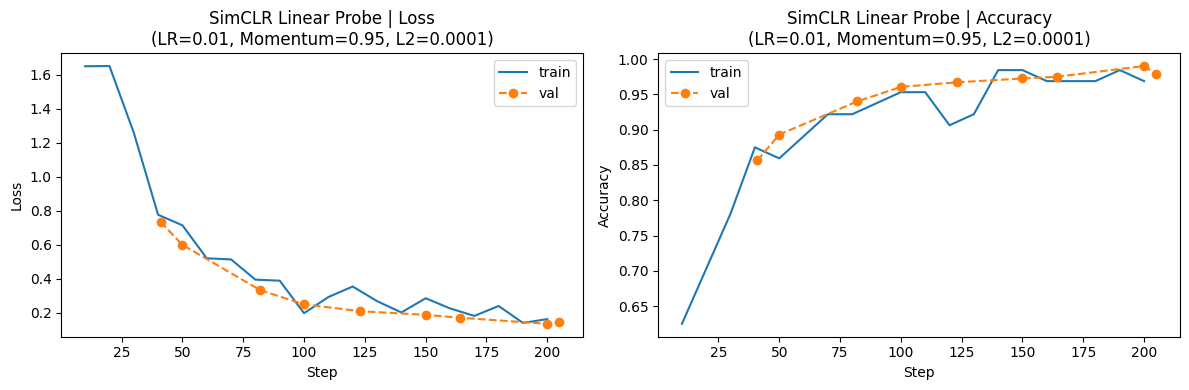

In [34]:
plot_logs(
    logs_3,
    learning_rate=0.01,
    momentum=0.95,
    l2_reg_weight=1e-4
)

In [ ]:
simclr_path = "gs://simclr-checkpoints-tf2/simclrv2/finetuned_100pct/r50_1x_sk0/saved_model/"
num_classes = train_info.features.label.num_classes
model_4 = SimCLRLinearClassifier(simclr_path, num_classes, weight_decay=0.0)

opt_4 = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.95, nesterov=True)
logs_4 = train(
    model_4,
    train_ds=train_ds,
    eval_ds=val_ds,
    epochs=5,
    optimizer=opt_4,
    l2_reg_weight=5e-3,
    log_every=10,
    eval_every=50,
    eval_max_batches=50,
    ckpt_path="best_linear_probe4.weights.h5"
)a


=== Epoch 1/5 ===
[step   10] loss=2.7395  acc=0.383
[step   20] loss=2.2471  acc=0.527
[step   30] loss=1.9963  acc=0.586
[step   40] loss=1.7696  acc=0.645
[Epoch 01 End] train_loss=1.7489  train_acc=0.650  val_loss=0.9045  val_acc=0.872

=== Epoch 2/5 ===
[step   50] loss=0.9065  acc=0.866
    Eval @ step   50: val_loss=0.8392  val_acc=0.892
     New best val_acc=0.8918 → saved weights to best_linear_probe4.weights.h5
[step   60] loss=0.8699  acc=0.875
[step   70] loss=0.8207  acc=0.886
[step   80] loss=0.7872  acc=0.894


2025-10-13 20:00:58.328650: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[Epoch 02 End] train_loss=0.7818  train_acc=0.894  val_loss=0.5844  val_acc=0.929

=== Epoch 3/5 ===
[step   90] loss=0.6305  acc=0.926
[step  100] loss=0.6030  acc=0.931
    Eval @ step  100: val_loss=0.4979  val_acc=0.948
     New best val_acc=0.9485 → saved weights to best_linear_probe4.weights.h5
[step  110] loss=0.5700  acc=0.938
[step  120] loss=0.5569  acc=0.944
[Epoch 03 End] train_loss=0.5537  train_acc=0.946  val_loss=0.4673  val_acc=0.965

=== Epoch 4/5 ===
[step  130] loss=0.4805  acc=0.962
[step  140] loss=0.4794  acc=0.962
[step  150] loss=0.4722  acc=0.965
    Eval @ step  150: val_loss=0.4202  val_acc=0.980
     New best val_acc=0.9801 → saved weights to best_linear_probe4.weights.h5
[step  160] loss=0.4714  acc=0.963
[Epoch 04 End] train_loss=0.4695  train_acc=0.964  val_loss=0.4188  val_acc=0.975

=== Epoch 5/5 ===
[step  170] loss=0.4248  acc=0.974
[step  180] loss=0.4295  acc=0.977
[step  190] loss=0.4332  acc=0.973
[step  200] loss=0.4296  acc=0.974
    Eval @ step

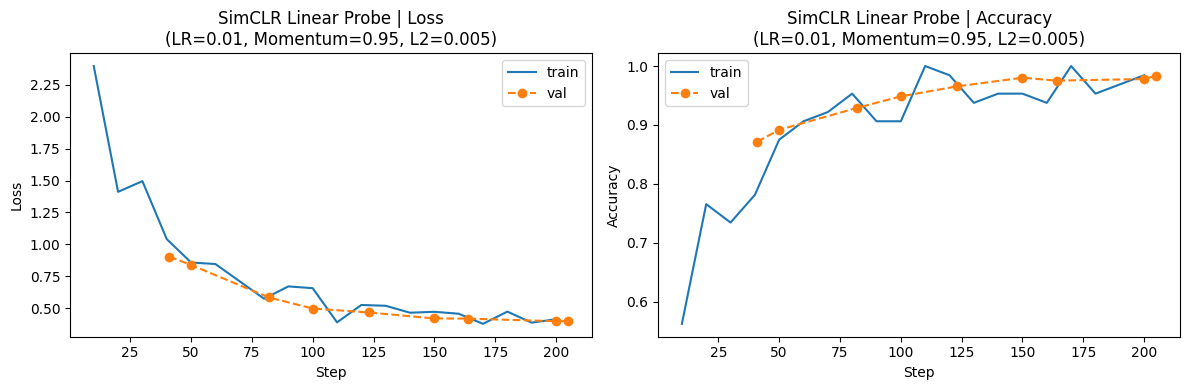

In [36]:
plot_logs(
    logs_4,
    learning_rate=0.01,
    momentum=0.95,
    l2_reg_weight=5e-3
)

In [37]:
def compare_logs(logs_list, labels=None, title_prefix="SimCLR Comparison"):
    """
    Plot val_loss and val_acc for multiple log dicts.
    logs_list : list of log dictionaries
    labels    : list of labels for the legend (same length as logs_list)
    """
    if labels is None:
        labels = [f"Run {i+1}" for i in range(len(logs_list))]

    plt.figure(figsize=(12,5))

    # ---- Validation Loss ----
    plt.subplot(1,2,1)
    for logs, label in zip(logs_list, labels):
        if logs.get("val_step") and logs.get("val_loss"):
            plt.plot(logs["val_step"], logs["val_loss"], marker='o', label=label)
    plt.title(f"{title_prefix} | Validation Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # ---- Validation Accuracy ----
    plt.subplot(1,2,2)
    for logs, label in zip(logs_list, labels):
        if logs.get("val_step") and logs.get("val_acc"):
            plt.plot(logs["val_step"], logs["val_acc"], marker='o', label=label)
    plt.title(f"{title_prefix} | Validation Accuracy")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


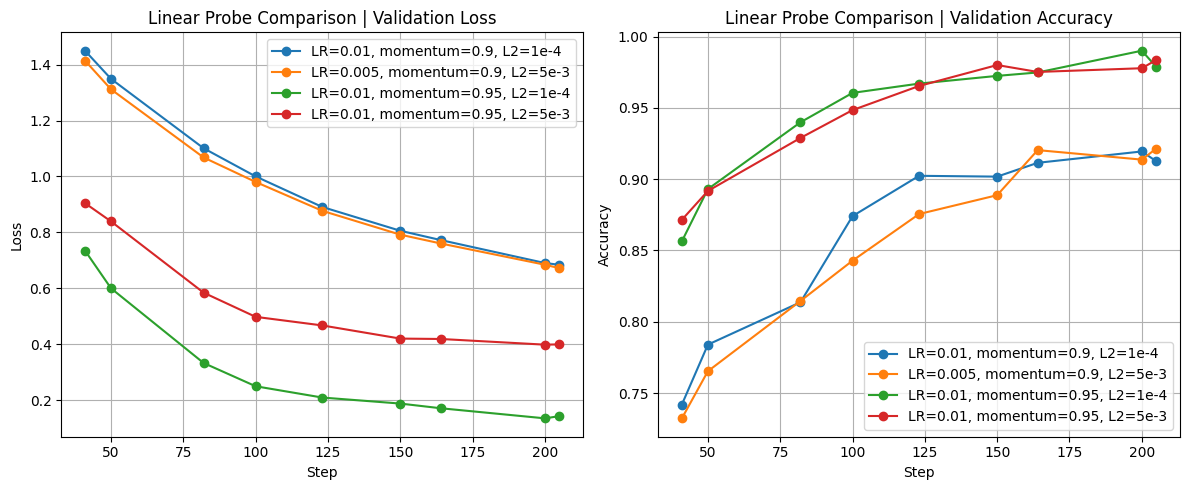

In [41]:
compare_logs(
    [logs, logs_2, logs_3, logs_4],
    labels=["LR=0.01, momentum=0.9, L2=1e-4",
            "LR=0.005, momentum=0.9, L2=5e-3",
            "LR=0.01, momentum=0.95, L2=1e-4",
            "LR=0.01, momentum=0.95, L2=5e-3"],
    title_prefix="Linear Probe Comparison"
)


### Results from Plots

I tried 4 different combinations of hyperparameter. I found momentum has a huge impact on both evaluation accuracy and loss. When I increase the momentum from 0.9 to 0.95, there is a clear improvement on both accuracy and loss. 

I also changed learning rate but from the above experiments (logs, logs_2), the model performance is not so sensitive to learning rate changes. 

Also, the l2 weight for the classfication head loss doesn't affect the accuracy. It only affect the loss which is expected as it is part of the loss function. 


### Final Thoughts:

I initial spent more than expected time to get the training dataset in the correct format and load the pretained weights. After that, everything becomes the standard process for training and a bit of hyperparameter tuning.

Another place I got stuck was that initially I didn't write the train_step function inside the SimCLRLinearClassifier class. This causes errors when I train another model with different hyperparameters with wants to reuse the older computation graph. By writing it inside the SimCLRLinearClassifier class, each model's computation graph would be different and won't cause any error.

As I was wrapping up and reading the prompt again, I realized that the better approach for this classification task is to finetine both the simclr encoder part and the classfication head as the goal is to have 0-shot or 1-shot model. The finetuned simclr encoder could be better at getting the representation for different symbols so that it could generalize well on new symbols. However, for the time of the take-home, I didn't implement this.